# Validator Returns with Post-merge MEV

As Ethereum approaches the point at which the beacon chain — launched in December 2020 — will become the consensus engine for mainnet, much online coverage has focused on the end of Proof of Work mining and concomitant reductions in both energy usage and issuance of Ether (never mind that Proof of Stake is [more secure a resistant to centralisation](https://vitalik.ca/general/2020/11/06/pos2020.html)). However another consequence of the beacon chain taking over transaction inclusion and ordering duties is that the fees currently paid to miners for transaction inclusion will instead be paid to the block *proposer*. That is, a validator, selected at random to propose a block every 12 seconds.

The manner in which validators are selected to propose blocks does not change from the existing process, and as I showed in my [first article on validator returns](https://pintail.xyz/posts/beacon-chain-validator-rewards/#block-rewards), this produces some random variation in revenue, even when validators participate perfectly. So for this article, the question is how much validator returns are affected by the fees they receive for including transactions on Ethereum's execution layer.

## But What's MEV?

In the title, I've referred to these execution layer fees as 'MEV'. Perhaps this is a little confusing — [the term MEV](https://docs.flashbots.net/Flashbots-auction/miners/faq/#what-is-mev) can stand for "miner extractable value" or "maximal extractable value" — neither of which seems to describe the fees received by validators for including/ordering transactions in post-merge Ethereum blocks. Validators are not miners, and in what sense might this value be 'maximal', anyway? The reality is that the term MEV has entered common usage to describe whatever value is — or could be — paid to the the entity responsible for transaction inclusion and ordering. To reduce the ambiguity, the Flashbots team have introduced the term "Realised Extractable Value" to describe the value actually obtained, rather than a theoretical maximum. However, since 'MEV' is the term with widespread adoption, it is what I will use here (I know [all too well](https://pintail.medium.com/uniswap-a-good-deal-for-liquidity-providers-104c0b6816f2) how difficult it can be to change a term once it has entered widespread use).

So why use a fancy term (MEV) when we could use a straightforward one (transaction fees)? The answer is that the revenue from transaction inclusion and ordering has been revolutionised since Flashbots introduced a fork of the dominant Ethereum execution client, geth. As of August 2022, [approximately 74%](https://dashboard.flashbots.net/) of Ethereum's hashrate is running mev-geth, since doing so allows miners to receive bundles of transactions which exploit time-sensitive profit opportunities and are rewarded with direct payment (previously much of this revenue was wasted in a wasteful *priority gas auction* process). The use of the term MEV recognises this new complexity. Furthermore, the opportunity for validators to benefit from the same revenue stream post-merge is being offered by Flashbots through [mev-boost](https://boost.flashbots.net/). However, whether or not validators choose to run mev-boost, the fees they receive for block proposal can still be described in a broad sense as MEV.

## Previous Model

An article setting out [an early exploration](https://hackmd.io/@flashbots/mev-in-eth2#) (with [accompanying notebook](https://github.com/flashbots/eth2-research/blob/main/notebooks/mev-in-eth2/eth2-mev-calc.ipynb)) of the implications of this change  was published by Alex Obadia and Taarush Vemulapalli from Flashbots in July 2021, by looking specifically at Flashbots transaction bundles from a sample of approx 100,000 blocks. Firstly they averaged across blocks, applying a fixed amount of MEV per block. Then they looked at the 1st and 99th centiles within that dataset to establish some bounds for the impact on validator returns (finding a very wide variation as a result of this approach).

In this article I'll develop this approach a bit further by:
1. Looking at fee revenue in its entirety (rather than only Flashbots bundles), since all miner fee revenue can be considered a form of MEV.
1. Using a larger dataset and considering how the levels of MEV have varied over time.
1. Modelling the whole distribution of outcomes.
1. Calculating how these distributions change for users running multiple validators.

One point observed in the above article was that it was difficult to reason about the impact of EIP-1559 on the fees paid to miners (the London hard fork which introduced EIP-1559 was not live at the time the article was written). Now however we have plenty of data on this — the stacked chart below shows the portion of the fees (in green) which were previously being paid to miners, but since the London hard fork are instead subtracted from the Ether supply (burned). Clearly data from before and after the London hard fork are not comparable. For that reason, in this article we will deal only with data from the period *after* the London hard fork.

In [1]:
import math
from random import randrange, random
from datetime import datetime, timedelta
from time import time

import psycopg2
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

from web3 import Web3

start_block = 12965000
end_block = 14714999

SECONDS_PER_SLOT = 12

# close any existing connection to mev-inspect database

try:
    cursor.close()
    connection.close()
except:
    pass

# connect to mev-inpect database

connection = psycopg2.connect(
    host="127.0.0.1",
    port=5433,
    user="postgres",
    password="password",
    database="mev_inspect"
)
connection.autocommit = True
cursor = connection.cursor()

# get block summary data from db as pandas dataframe

sql = (
    "SELECT * FROM block_totals WHERE block_number BETWEEN %s AND %s "
    "ORDER BY block_number"
)
cursor.execute(sql, (start_block, end_block))

(
    block_numbers, block_timestamps, base_fees, gas_used,
    net_transfers, net_fees, burned_fees, ts_diff_1, ts_diff_2
) = zip(*cursor.fetchall())

miner_extracted = [float(t + f) for t, f in zip(net_transfers, net_fees)]

# save data into a pandas dataframe 

df = pd.DataFrame({
    'block_number': [int(bn) for bn in block_numbers],
    'timestamp': pd.to_datetime(block_timestamps),
    'gas_used': [int(gu) for gu in gas_used],
    'base_fee': [int(bf) for bf in base_fees],
    'net_transfers': [float(nt) for nt in net_transfers],
    'net_fees': [float(nf) for nf in net_fees],
    'miner_extracted': miner_extracted,
    'burned_fees': [float(bf) for bf in burned_fees],
    'ts_diff_1': [int(ts) for ts in ts_diff_1],
    'ts_diff_2': [int(ts) for ts in ts_diff_2]
})

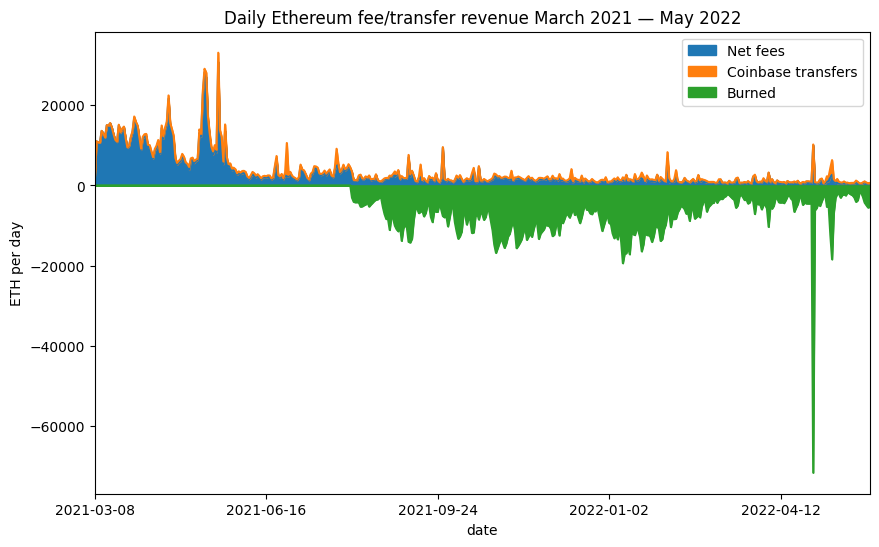

In [2]:
daily = pd.read_csv('daily_totals.csv')
daily['net_fees'] = daily['total_fee_revenue'] - daily['total_basefee_cost']
daily['burned_ether'] = -1 * daily['total_basefee_cost']

fig, ax = plt.subplots(figsize=(10, 6))

daily.set_index('date', inplace=True)
daily.rename(inplace=True, columns={
    'net_fees': 'Net fees',
    'total_transfer_revenue': 'Coinbase transfers',
    'burned_ether': 'Burned'
})
daily[['Net fees', 'Coinbase transfers', 'Burned']].plot.area(
    ax=ax, ylabel="ETH per day"
)
ax.margins(x=0)
ax.set_title('Daily Ethereum fee/transfer revenue March 2021 — May 2022');

## Selecting a Dataset

For the rest of this article, we're going to work with historical data to try and get a sense of roughly what to expect in the future (while remembering that in things financial, such an approach is not reliable). Nonetheless to try and draw some general conclusions, we'd like to select the largest dataset available for which the protocol has been stable. As explained in my [last article](https://pintail.xyz/posts/gas-market-analysis/), the transaction fee market changed significantly in August 2021 due to the implementation of EIP-1559 as part of the London hard fork which went live at block 12,965,000. The hard fork following this was [Gray Glacier](https://blog.ethereum.org/2022/06/16/gray-glacier-announcement), which went live at block 15,050,000 and pushed back Ethereum's difficulty bomb. However, average block intervals had begun to change a while before this, changing network conditions. We'll therefore look at the data up to block 14,714,999 which was mined in May 2022. This gives us 1,750,000 blocks — approximately 9 months of data — to work with.

Having chosen this block range, we need to identify how much revenue is going to the miner of each block. For this we'll be using Flashbots' [mev-inspect-py](https://github.com/flashbots/mev-inspect-py) tool which (amongst many other features) scrapes blocks for "coinbase transfer" transactions as well as aggregating fees. This is because there are two main ways in which miners are paid for including Flashbots bundles of MEV-carrying transactions — either by setting a sufficiently high transaction fee, or including a direct payment to the miner as part of the transaction. [For reasons of gas-efficiency](https://youtu.be/dBvAcDkIe2Y) there has been a tendency towards searchers using gas fees rather than coinbase transfers to pay miners. Still, we'd like to include both in our dataset for a more complete picture.

We have to do a little bit more work to determine the amount of MEV per block. First we have to exclude transactions that miner pay to themselves since these are not economically meaningful. This requires identifying multiple addresses controlled by a single mining pool (this involved some manual sleuthing on Etherscan) and then labelling each transaction according to whether its sender address was in a mining pool group, and labelling each block according the mining pool which produced it ([see script 1](https://github.com/pintail-xyz/post-merge-mev/blob/master/add_miner_labels.py)). Once this was done, it was possible to produce a per-block MEV summary which subtracted the Ether burned by EIP-1559 and excluded intra-pool transfers, with the results saved as an extra table in the Postgres database populated by mev-inspect-py ([see script 2](https://github.com/pintail-xyz/post-merge-mev/blob/master/block_totals.py)).

Finally, [one transaction](https://etherscan.io/tx/0x2c9931793876db33b1a9aad123ad4921dfb9cd5e59dbb78ce78f277759587115) stood out as having a much larger transaction fee than any other (7676 ETH). In fact this transaction fee on its own was worth about USD 23m, and accounted for a significant proportion of all the MEV extracted over the period. It turned out in this case the high fee was [the result of a bug](https://rhino.fi/blog/23-7-million-dollar-ethereum-transaction-fee-post-mortem/) and in fact the vast majority of the fee was returned by the miner. With this in mind I chose to exclude this transaction from the dataset.

## Historical MEV levels

Now that we have our dataset of 1.75m blocks / 9 months, let's take a look at how much MEV a miner could expect to receive in a typical block. The two plots below illustrate this. The histogram (upper) shows that per-block miner revenue is most often very low — with frequencies for higher amounts of miner revenue dropping off rapidly. The second plot may be slightly less intuitive but actually tells us much more. We can see that the median miner revenue is 0.09 ETH (i.e. 50% of blocks paid their miners this amount or less, 50% paid more). A few other points have been marked on the plot, so we can see the lowest-value 1% of blocks paid nothing at all to the miner, whereas the highest-value 1% of blocks paid over 1.9 ETH to the miner. As shown in the table below (but not on the chart, since it would distort the axes too much), the top 0.1% of blocks paid over 14.5 ETH to the miner.

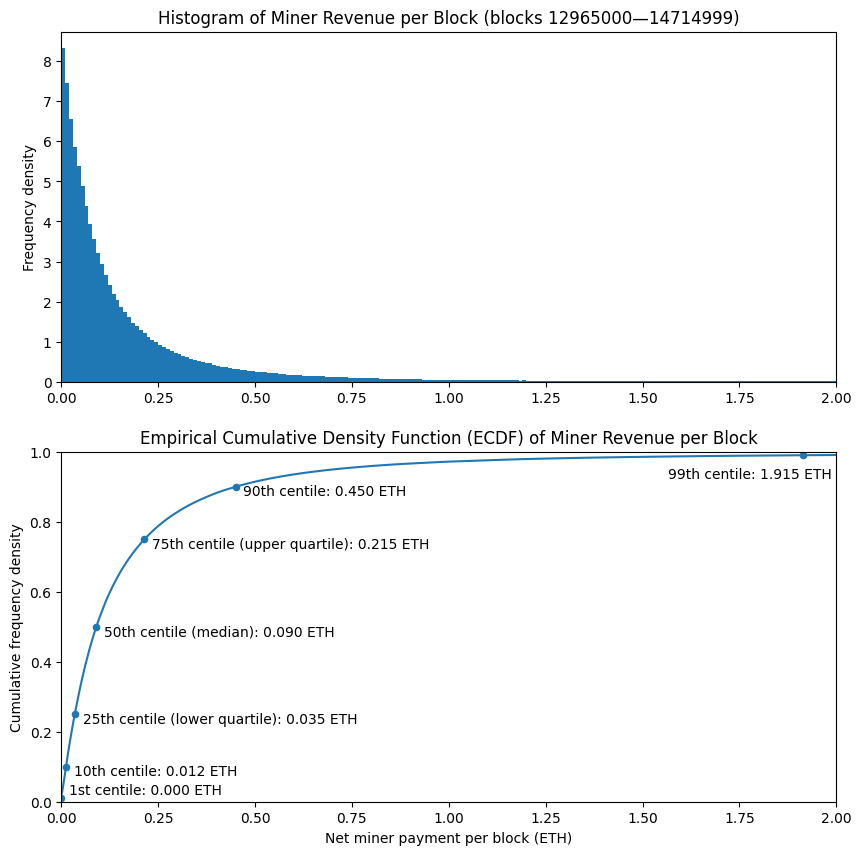

centile,revenue
1.0%,0.000
10.0%,0.012
25.0%,0.035
50.0%,0.090
75.0%,0.215
90.0%,0.450
99.0%,1.915
99.9%,14.542


In [3]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/100 for e in range(201)]
df['miner_extracted'].hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of Miner Revenue per Block (blocks 12965000—14714999)')
ax1.set_xlim(0, 2)
ax1.set_ylabel('Frequency density')

vc = df['miner_extracted'].value_counts()
ecdf = vc.sort_index().cumsum()*1./len(df)

ecdf.plot(ax=ax2, label='ECDF')

quantiles = [.01, .1, .25, .5, .75, .9, .99, .999]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'revenue': [ecdf[ecdf.ge(q)].index[0] for q in quantiles],
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('revenue', 'quantile', kind='scatter', ax=ax2)

ax2.set_title(
    'Empirical Cumulative Density Function (ECDF) of Miner Revenue per Block'
)
ax2.set_xlim(0,2)
ax2.set_xlabel('Net miner payment per block (ETH)')
ax2.set_ylim(0,1)
ax2.set_ylabel('Cumulative frequency density')

c1 = table['revenue'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.3f} ETH', (c1 + 0.02, 0.02))
d1 = table['revenue'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.3f} ETH', (d1 + 0.02, 0.075))
lq = table['revenue'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.3f} ETH', (lq + 0.02, 0.225))
med = table['revenue'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.3f} ETH', (med + 0.02, 0.475))
uq = table['revenue'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.3f} ETH', (uq + 0.02, 0.725))
d9 = table['revenue'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.3f} ETH', (d9 + 0.02, 0.875))
c99 = table['revenue'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.3f} ETH', (c99 - 0.35, 0.925))

plt.show()

table[['centile', 'revenue']].style.hide().format(
    {'centile': '{:.1f}%', 'revenue': '{:.3f}'}
)

## MEV Trends
The histogram and ECDF above are based on taking our whole 9-month dataset and treating it as though it were one static distribution. However, we might think that levels of miner revenue would vary over time, and that the distribution of miner revenue might depend on various factors like the level of on-chain activity, or by trends around the proportion of available MEV which is paid to miners, or the amount of MEV available on the base chain as compared with L2 blockchains.

To investigate this, the chart below shows the median block reward for each week of the dataset, with the overall median we saw previously indicated by the dashed line. The reason to do this on a weekly basis is that on-chain activity tends to follow a weekly cycle, with lower activity at the weekends. From this chart, clearly the weekly median level of miner revenue was higher in the earlier portion of the dataset than later on. During this 9-month period, the overall trend for miner revenue appears to be downwards, although the reasons for this are not clear. One thing that this should tell us however is that we cannot have a great deal of confidence in any estimates of future revenue which are based on historical data (keep this in mind, since it is exactly what I will be doing in the latter portion of this article).

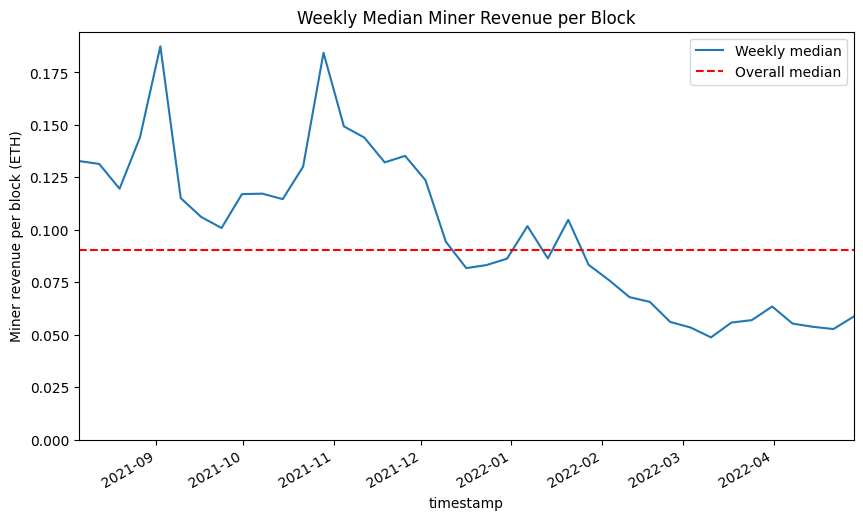

In [4]:
nanoseconds_per_week = 10**9 * 60 * 60 * 24 * 7
df['week'] = (
    df['timestamp'].astype(int) - df['timestamp'].astype(int).iloc[0]
) // nanoseconds_per_week
weekly_data = {
    'timestamp': df.groupby(['week'])['timestamp'].first(),
    'median': df.groupby(['week'])['miner_extracted'].quantile(0.5)
}
weekly = pd.DataFrame(weekly_data)

fig, ax = plt.subplots(figsize=(10, 6))
weekly.set_index('timestamp', inplace=True)
weekly['median'].plot(ax=ax, label='Weekly median')
ax.axhline(med, color='r', linestyle='dashed', label='Overall median')
ax.set_title('Weekly Median Miner Revenue per Block')
ax.set_ylabel('Miner revenue per block (ETH)')
ax.set_ylim(ymin=0)
ax.set_xlim(weekly.index.min(), weekly.index.max())
ax.legend();

Since the levels of miner revenue across our 9-month dataset do not appear to be static, let's try comparing the first half of the dataset with the second half in a more detailed way. In the plot below you can see the ECDFs for the two halves of the dataset. The fact that the blue line (representing the first half of the dataset) sits below the orange line (representing the second half) and since we have revenue along the x-axis, this means that at every quantile, the levels of miner revenue were lower in the first half of the dataset. The ECDF for the whole dataset which was shown in the previous plot would fall in between these two lines.

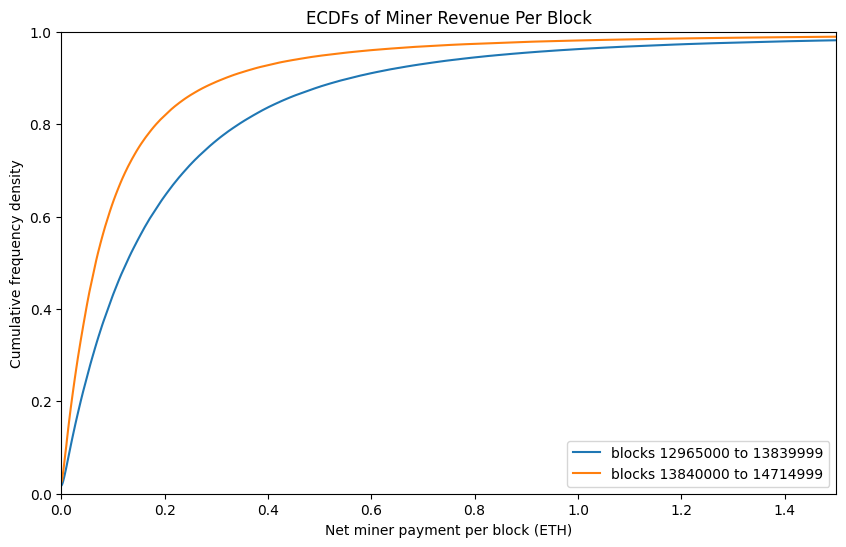

centile,blocks 12965000to 13839999,blocks 13840000to 14714999
1.0%,0.000,0.000
10.0%,0.018,0.009
25.0%,0.049,0.026
50.0%,0.126,0.067
75.0%,0.285,0.150
90.0%,0.560,0.318
99.0%,2.165,1.589
99.9%,15.031,13.984


In [5]:
df_h1 = df.iloc[:len(df) // 2]
vc_h1 = df_h1['miner_extracted'].value_counts()
ecdf_h1 = vc_h1.sort_index().cumsum()*1./len(df_h1)

df_h2 = df.iloc[len(df) // 2:]
vc_h2 = df_h2['miner_extracted'].value_counts()
ecdf_h2 = vc_h2.sort_index().cumsum()*1./len(df_h2)

fig, ax = plt.subplots(figsize=(10, 6))
ecdf_h1.plot(ax=ax, label='blocks 12965000 to 13839999')
ecdf_h2.plot(ax=ax, label='blocks 13840000 to 14714999')

ax.set_title('ECDFs of Miner Revenue Per Block')
ax.set_xlim(0,1.5)
ax.set_xlabel('Net miner payment per block (ETH)')
ax.set_ylim(0,1)
ax.set_ylabel('Cumulative frequency density')
ax.legend()
plt.show()

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({
    'centile': [100 * q for q in quantiles],
    'blocks 12965000<br>to 13839999': [
        ecdf_h1[ecdf_h1.ge(q)].index[0] for q in quantiles
    ],
    'blocks 13840000<br>to 14714999': [
        ecdf_h2[ecdf_h2.ge(q)].index[0] for q in quantiles
    ]
})
table.style.hide().format({
    'centile': '{:.1f}%',
    'blocks 12965000<br>to 13839999': '{:.3f}',
    'blocks 13840000<br>to 14714999': '{:.3f}'
})

## Digression: Block Intervals

So having looked at the distributions of MEV in historical data, what can we infer about likely returns for validators? As I hinted earlier, the real answer is *not very much* since the distribution of per-block revenue is not static and depends on many factors which make it hard to predict. Of course, that's not going to stop me using this data to model what post-merge returns would look like, imagining that historically-observed levels of MEV should persist after the merge! But before we go ahead and misuse this somewhat arbitrary dataset, there is one difference between pre-merge and post-merge block production which we might like to take into account. That aspect is the block interval.

After the merge, rather than having random block intervals with an average of about 13.5s, we will have a fixed block interval of 12s. The obvious consequence of this is that post-merge Ethereum will have slightly higher throughput by virtue of having slightly more frequent blocks. However, the subtler consequence is that the variability of block intervals will decrease dramatically. In pre-merge (i.e. proof of work) Ethereum, the amount of time between blocks successive blocks follows (roughly) an exponential distribution. This is because Ethereum block production is well-modelled as a *Poisson process* — that is, the probability of finding the next block within time $\delta$ remains constant. Take a look at the histogram of block intervals below, which is based on the timestamps which miners attach to their blocks.

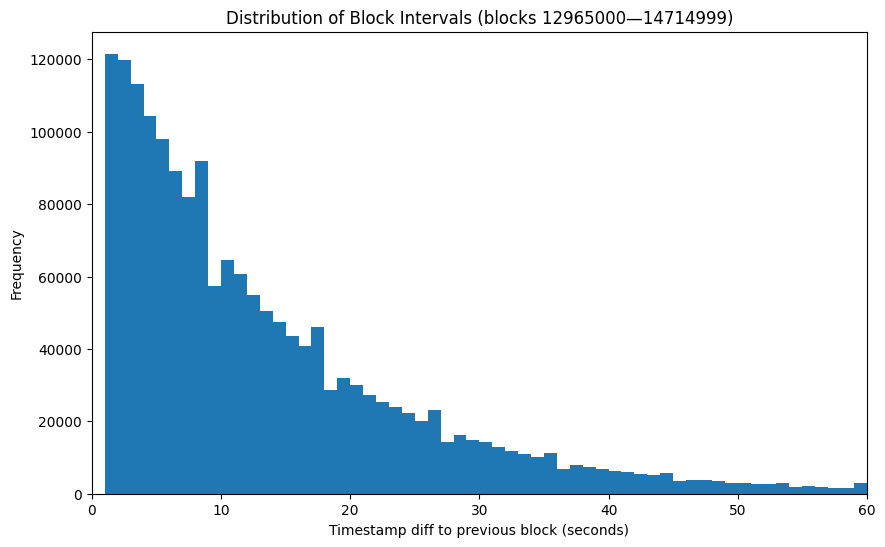

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
df['ts_diff_1'].plot.hist(bins=[b for b in range(61)], ax=ax)
ax.set_xlabel('Timestamp diff to previous block (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Block Intervals (blocks 12965000—14714999)')
ax.set_xlim(xmin=0, xmax=60);

This chart shows that in broad outline the block interval on pre-merge Ethereum does in broad outline follow the the shape of an exponential distribution. It's not perfect — timestamp resolution is only down to 1s, and no two blocks in the canonical chain can have the same timestamp (hence no bar at 0s).

The slightly more confusing effect is the surplus of blocks that show up in every 9th second of the distribution. Remember I said that the timestamps on blocks are self-reported by the block's miner? It turns out that some miners appear to have abused this power to slightly reduce their risk of mining an uncle block and hence increase their profitability:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Do miners execute consensus-level attack against Ethereum (or other major tokens)❓🤔<br>The answer is *yes*❗🤯<br>Read on for full deets 👇<br>Joint work with Gilad Stern and <a href="https://twitter.com/Avivz78?ref_src=twsrc%5Etfw">@Avivz78</a>.<br>Full paper: <a href="https://t.co/PffJRQ3X3W">https://t.co/PffJRQ3X3W</a><br>Medium post: <a href="https://t.co/qMOsRrN5DJ">https://t.co/qMOsRrN5DJ</a><br>... (1/12)</p>&mdash; Aviv Yaish (@yaish_aviv) <a href="https://twitter.com/yaish_aviv/status/1555445499041300481?ref_src=twsrc%5Etfw">August 5, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

But this really does digress excessively from our main concern, which is the impact of block interval variability on fee revenue. The thing is, as is clear from the distribution above, blocks are very frequently mined in quick succession. There are also sometimes very long intervals between successive blocks — a minute or more. Intuitively, we might think that a longer block interval means more time to collect more fees, and therefore greater miner revenue. To investigate this I looked at the median miner revenue from blocks, plotted below, grouped by the timestamp difference from block $n$ to block $n-1$ (blue line), and then by the time difference between blocks $n-1$ and $n-2$ (orange line).

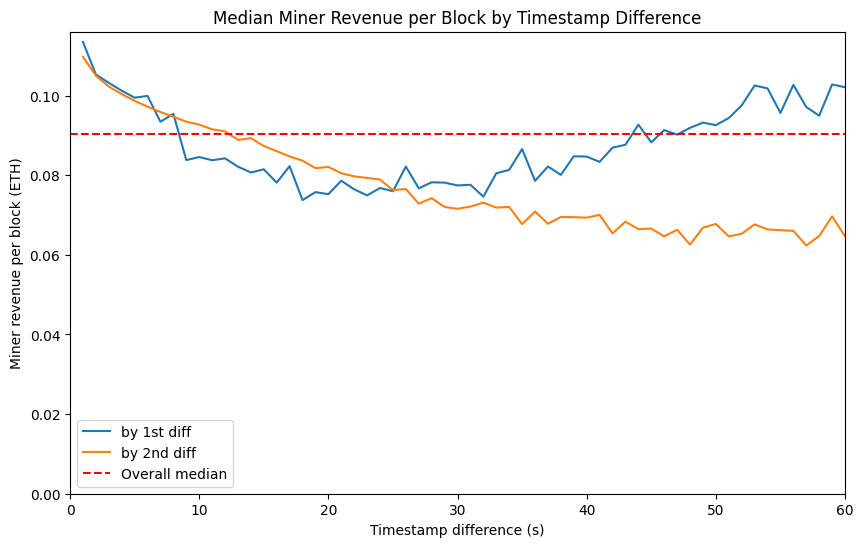

In [11]:
diff1_med = df.groupby('ts_diff_1')['miner_extracted'].median()
diff2_med = df.groupby('ts_diff_2')['miner_extracted'].median()
fig, ax = plt.subplots(figsize=(10, 6))
diff1_med[:61].plot(ax=ax, label='by 1st diff')
diff2_med[:61].plot(ax=ax, label='by 2nd diff')
ax.axhline(med, color='r', linestyle='dashed', label='Overall median')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0, xmax=60)
ax.set_title('Median Miner Revenue per Block by Timestamp Difference')
ax.set_xlabel('Timestamp difference (s)')
ax.set_ylabel('Miner revenue per block (ETH)')
ax.legend();

What we observe is confusing. Based on the first timestamp difference, rewards seem to drop off initially and then build up for longer block intervals. When we look at the second timestamp difference, MEV rates seem only to reduce further and further, the longer the block interval. I have theories about why these patterns might be. But I will move on rather than present them here because (a) I'm not confident about them and (b) this problem is no longer relevant post-merge, once block times are fixed.

What I will conclude from this digression is that the block interval does not seem to have a dramatic impact on miner revenue — the median by block interval remains within about 20% of the overall median. Therefore for the remainder of this article, I will treat post-merge miner revenue as being broadly equivalent to pre-merge miner revenue, and will not make allowances for the change from a variable to fixed block interval. We might reasonably expect that variability of miner revenue will decrease somewhat as a result of the reduced variability in block interval, but the effect will not be large.

I will make some attempt to try and account for the slightly increased average frequency of blocks, going from a mean interval of 13.5s to 12s, by inversely scaling all miner revenue amounts by this ratio. Of course, real markets are more complicated than this, but absent a more rigorous way of accounting for this difference, proportional scaling will have to do.

## Simulating Post-Merge Returns

So, bringing together what we have learned about historical block revenues for miners, let's have a go at modelling what validator returns from MEV might look like over the course of a year. Since we're now thinking about validators instead of miners, I'll express the results as percentage return on 32 ETH. We haven't arrived at an analytical expression for the distribution of per-block revenues (in my time spent trying to come up with a sensible expression based on a Pareto distribution, a suitable formulation proved elusive). This slightly complicates modelling and means in this case we're going to resort to a Monte Carlo simulation.

The basic methodology is simple — generate a random number uniformly distributed between 0 and 1, and use this number to perform a lookup from the ECDF we calculated earlier (with the ECDF scaled to account for the 13.5s to 12s change in average block intervals). Assign the block's revenue to a randomly selected validator. Repeat until we have a year's worth of simulated blocks (2,629,746 blocks in total).

Initially we're going to assume perfect validator performance (no missed block proposals). We're also going to use a validator set size of $2^19=524,288$ validators. This is a larger set than the approximately 420k validators on the beacon chain as of August 2022. However, with the increase in validator post-merge, we would expect the validator set will continue to grow, so a larger simulate validator set slightly future-proofs the modelling. Using a power of 2 is also convenient as it makes it easier to divide the validator set into groups.

In [19]:
# calculate average block interval
mean_interval = (df['timestamp'].max() - df['timestamp'].min()) / (len(df) - 1)
scaling_factor = SECONDS_PER_SLOT / mean_interval.total_seconds()
index = [v * scaling_factor for v in ecdf.index.values]
scaled_ecdf = ecdf.copy().set_axis(index)

num_validators = 2**19 # assume 2**19 validators (524,288)
validators = [[] for i in range(num_validators)]
seconds_per_year = 31556952
slots_per_year = seconds_per_year // 12

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # random selection of validator as proposer
    validators[randrange(num_validators)].append(
        # random sampling of MEV level for the block
        #scaled_ecdf[scaled_ecdf.ge(random())].index[0]
        scaled_ecdf.index[np.argmax(scaled_ecdf.array >= random())] # faster
    )
    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

rtn = pd.Series(
    [100 * sum(validators[i]) / 32 for i in range(num_validators)]
)
validator_ecdf = rtn.value_counts().sort_index().cumsum() / num_validators

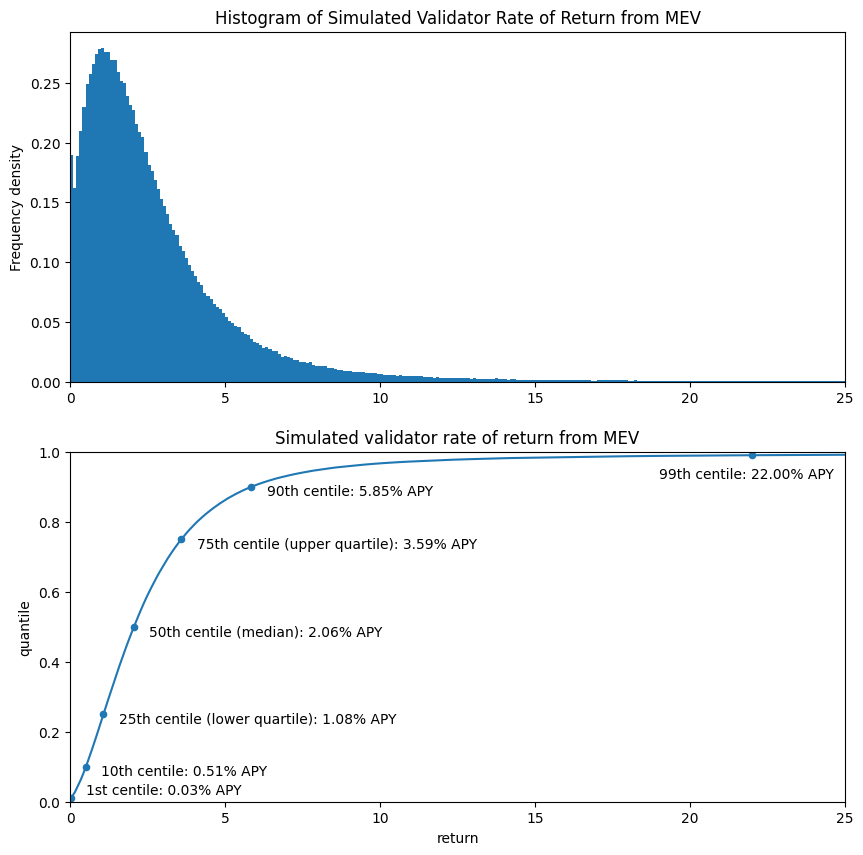

centile,return
1.0%,0.03
10.0%,0.51
25.0%,1.08
50.0%,2.06
75.0%,3.59
90.0%,5.85
99.0%,22.00
99.9%,182.60


In [37]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/10 for e in range(251)]
rtn.hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of Simulated Validator Rate of Return from MEV')
ax1.set_xlim(0, 25)
ax1.set_ylabel('Frequency density')

validator_ecdf.plot(ax=ax2)
ax2.set_title('Simulated validator rate of return from MEV')
ax2.set_xlabel('Annual rate of return (%)')
ax2.set_xlim(0, 25)
ax2.set_ylabel('Cumulative frequency density')
ax2.set_ylim(0, 1)

quantiles = [.01, .1, .25, .5, .75, .9, .99, .999]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'return': [validator_ecdf[validator_ecdf.ge(q)].index[0] for q in quantiles]
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('return', 'quantile', kind='scatter', ax=ax2)

c1 = table['return'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.2f}% APY', (c1 + 0.5, 0.02))
d1 = table['return'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.2f}% APY', (d1 + 0.5, 0.075))
lq = table['return'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.2f}% APY', (lq + 0.5, 0.225))
med = table['return'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.2f}% APY', (med + 0.5, 0.475))
uq = table['return'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.2f}% APY', (uq + 0.5, 0.725))
d9 = table['return'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.2f}% APY', (d9 + 0.5, 0.875))
c99 = table['return'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.2f}% APY', (c99 - 3, 0.925))

plt.show()

table[['centile', 'return']].style.hide().format(
    {'centile': '{:.1f}%', 'return': '{:.2f}'}
)

quantile,1,2,4,8,16,32
10.0%,0.512053,0.969923,1.376092,1.723303,2.006437,2.244076
25.0%,1.077672,1.506881,1.850372,2.123772,2.341415,2.520802
50.0%,2.061650,2.340226,2.537260,2.681668,2.803718,2.917542
75.0%,3.592363,3.551912,3.512480,3.479663,3.486334,3.547694
90.0%,5.853010,5.346608,4.993080,4.810250,4.859205,5.107855
99.0%,22.004323,23.363758,25.759353,22.738997,18.144918,15.883192
99.9%,182.601416,135.890989,120.796960,74.756432,44.287081,29.988836


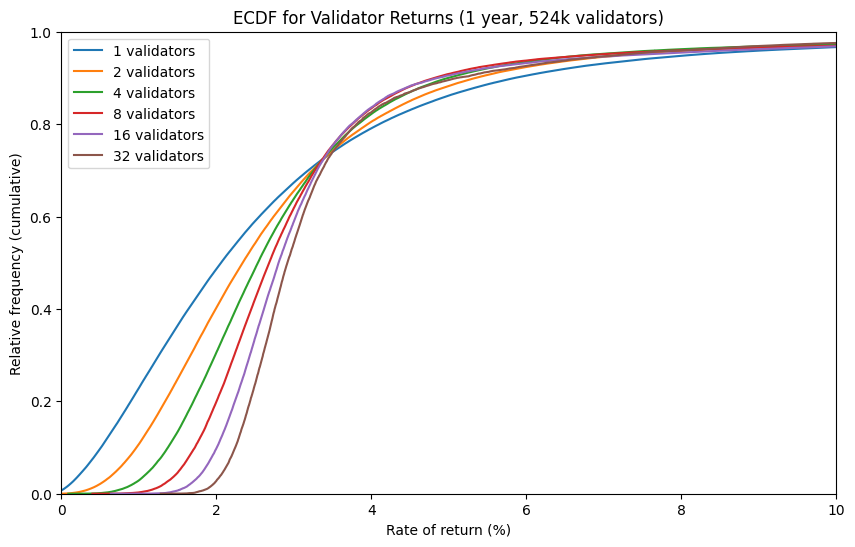

In [9]:
def sumlists(l):
    return sum([item for sublist in l for item in sublist])

rtns = []
ecdfs = []
for e in range(6):
    rtns.append(pd.Series([
        100 * sumlists(validators[i:i+2**e]) / (32 * 2**e)
        for i in range(0, num_validators, 2**e)
    ]))
    ecdfs.append(
        rtns[-1].value_counts().sort_index().cumsum() * 2**e / num_validators
    )

fig, ax = plt.subplots(figsize=(10, 6))
for e in range(6):
    ecdfs[e].plot(ax=ax, label=f'{2**e} validators')

ax.set_xlim(0,10)
ax.set_ylim(0,1)
ax.set_title("ECDF for Validator Returns (1 year, 524k validators)")
ax.set_xlabel("Rate of return (%)")
ax.set_ylabel("Relative frequency (cumulative)")
ax.legend();
    
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({'quantile': [100 * q for q in quantiles]})
for e in range(6):
    table[2**e] = [ecdfs[e][ecdfs[e].ge(q)].index[0] for q in quantiles]

table.style.hide().format({'quantile': '{:.1f}%'})

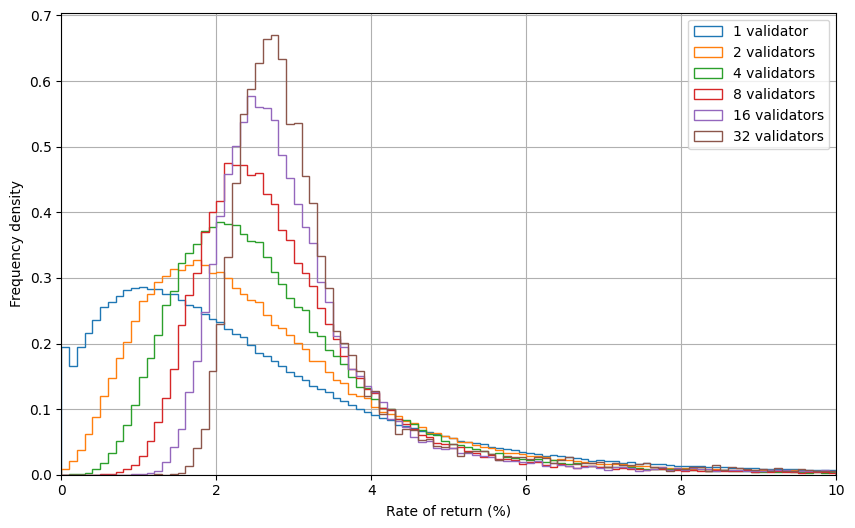

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
bins = [i / 10 for i in range(101)]
for e in range(6):
    label = f'{2**e} validators' if e > 0 else '1 validator'
    rtns[e].hist(ax=ax, density=True, bins=bins, label=label, histtype='step')
ax.set_xlim(0,10)
ax.set_ylim(ymin=0)
ax.set_xlabel("Rate of return (%)")
ax.set_ylabel("Frequency density")
ax.legend();

# To Do
* Address fixed block times
* Look into what proportion of MEV is actually being paid to the miner
* Mention that multi-block MEV becomes possible post-Merge
* Layer MEV revenue on top of the Altair modelling